<a href="https://colab.research.google.com/github/saqibmobin/BBC-Text-Classification/blob/master/BBC_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [0]:
import torchtext
from torchtext import data
import pandas as pd
import numpy as np
import re
import os
import zipfile

from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!python -m spacy download en 

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [8]:
df = pd.read_csv('./bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


**Splitting the input data into training and validation dataframe in 70:30 ratio**

In [0]:
traindf, valdf = train_test_split(df, test_size=0.3, random_state=2019)

In [10]:
print(len(traindf))
traindf.head()
traindf.category.value_counts()

1557


sport            367
business         354
tech             291
politics         290
entertainment    255
Name: category, dtype: int64

In [11]:
print(len(valdf))
valdf.head()
valdf.category.value_counts()

668


business         156
sport            144
entertainment    131
politics         127
tech             110
Name: category, dtype: int64

In [0]:
traindf.to_csv('./traindf.csv', index=False)
valdf.to_csv('./valdf.csv', index=False)

In [0]:
import spacy
spc = spacy.load('en', disable=['parser', 'tagger', 'ner'])

def clean_text(text):                  
  text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  #Removing non alpha numeric characters
  return text.strip()
                         

def tokenize(s):
  return [w.text.lower() for w in spc(clean_text(s))]  #defining tokenizer for text

def l_tokenize(l):
  return [w.text.lower for w in spc(s)]                #defining tokrnizer for label

In [0]:
## define the columns that we want to process and how to process

text_field = data.Field(sequential=True,
                      tokenize = tokenize,
                      include_lengths=True,
                      use_vocab=True)

label_field = data.Field(sequential=False,
                         tokenize = l_tokenize,
                         include_lengths=False,
                         use_vocab=True,
                         pad_token=None,
                         unk_token=None)

In [0]:
train_val_feilds = [('category', label_field),   #process it as text
                   ('text', text_field)          #process it as label
                   ]

In [0]:
#Create torchtext dataset

train_ds, val_ds = data.TabularDataset.splits(path='./',
                                              format='csv',
                                              train='traindf.csv',
                                              validation='valdf.csv',
                                              fields = train_val_feilds,
                                              skip_header=True)

In [17]:
type(train_ds)

torchtext.data.dataset.TabularDataset

In [18]:
len(train_ds), len(val_ds)

(1557, 668)

In [19]:
train_ds.fields.items()

dict_items([('category', <torchtext.data.field.Field object at 0x7f19156eff28>), ('text', <torchtext.data.field.Field object at 0x7f19156efeb8>)])

In [20]:
#example object 
ex = train_ds[0]
print(ex.category)
print(ex.text)

sport
['london', 'hope', 'over', 'chepkemei', 'london', 'marathon', 'organisers', 'are', 'hoping', 'that', 'banned', 'athlete', 'susan', 'chepkemei', 'will', 'still', 'take', 'part', 'in', 'this', 'year', 's', 'race', 'on', '17', 'april', 'chepkemei', 'was', 'suspended', 'from', 'all', 'competition', 'until', 'the', 'end', 'of', 'the', 'year', 'by', 'athletics', 'kenya', 'after', 'failing', 'to', 'report', 'to', 'a', 'national', 'training', 'camp', 'we', 'are', 'watching', 'it', 'closely', 'said', 'london', 'race', 'director', 'david', 'bedford', 'there', 'is', 'a', 'long', 'way', 'to', 'go', 'before', 'the', 'race', 'and', 'we', 'are', 'hoping', 'the', 'situation', 'will', 'be', 'satisfactorily', 'resolved', 'the', 'camp', 'in', 'embu', 'was', 'to', 'prepare', 'for', 'the', 'iaaf', 'world', 'cross', 'country', 'championships', 'later', 'this', 'month', 'chepkemei', 'however', 'took', 'part', 'and', 'finished', 'third', 'in', 'last', 'sunday', 's', 'world', 'best', '10k', 'race', 'in',

In [21]:
ex1 = val_ds[0]
print(ex1.category)
print(ex1.text)

business
['bmw', 'to', 'recall', 'faulty', 'diesel', 'cars', 'bmw', 'is', 'to', 'recall', 'all', 'cars', 'equipped', 'with', 'a', 'faulty', 'diesel', 'fuel', 'injection', 'pump', 'supplied', 'by', 'parts', 'maker', 'robert', 'bosch', 'the', 'faulty', 'part', 'does', 'not', 'represent', 'a', 'safety', 'risk', 'and', 'the', 'recall', 'only', 'affects', 'pumps', 'made', 'in', 'december', 'and', 'january', 'bmw', 'said', 'that', 'it', 'was', 'too', 'early', 'to', 'say', 'how', 'many', 'cars', 'were', 'affected', 'or', 'how', 'much', 'the', 'recall', 'would', 'cost', 'the', 'german', 'company', 'is', 'to', 'extend', 'a', 'planned', 'production', 'break', 'at', 'one', 'of', 'its', 'plants', 'due', 'to', 'the', 'faulty', 'bosch', 'part', 'the', 'dingolfing', 'site', 'will', 'now', 'be', 'closed', 'all', 'next', 'week', 'instead', 'of', 'for', 'just', 'two', 'days', 'the', 'additional', 'three', 'day', 'stoppage', 'will', 'mean', 'a', 'production', 'loss', 'of', 'up', 'to', '3', '600', 'vehicl

In [22]:
#downloading pretrained GloVe word embeddings

!wget --no-check-certificate \
    "http://nlp.stanford.edu/data/wordvecs/glove.6B.zip" \
    -O "/tmp/glove.6B.zip"

--2019-07-12 19:34:27--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip [following]
--2019-07-12 19:34:27--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2019-07-12 19:34:27--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [applic

In [0]:
#extracting

local_zip = '/tmp/glove.6B.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [24]:
os.listdir('/tmp')

['glove.6B.100d.txt',
 'glove.6B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.zip',
 'glove.6B.200d.txt']

## **Load pretrained word vectors and building vocabulary**

In [25]:
from torchtext import vocab

# specify the path to the localy saved vectors

vec = vocab.Vectors('glove.6B.50d.txt', '/tmp')

100%|█████████▉| 398560/400001 [00:10<00:00, 39290.92it/s]

In [0]:
# build the vocabulary using train and validation dataset and assign the vectors

text_field.build_vocab(train_ds, val_ds, max_size=20000, vectors=vec)

In [0]:
# build vocab for labels

label_field.build_vocab(train_ds)

In [28]:
print(text_field.vocab.vectors.shape)

torch.Size([20002, 50])


In [29]:
text_field.vocab.vectors[text_field.vocab.stoi['london']]

tensor([ 0.0329,  0.9964, -0.6975, -0.5838,  0.0534, -0.3576, -0.9674, -0.0482,
        -0.2342, -0.3164, -0.0802,  0.0075, -0.6921, -0.1936,  0.0405,  0.7449,
         0.0790, -0.1389, -1.5938,  0.3382,  2.5535,  0.8758, -0.1597,  0.8576,
        -0.6816, -1.3948,  0.1319,  0.1013, -0.7461,  0.6739,  2.5619, -0.1992,
         0.7675, -0.4867,  0.3974, -0.6253,  0.6350, -0.1989, -0.0953, -0.2247,
         0.6170, -0.2197,  0.2584, -0.3937,  0.4757,  0.5774, -0.5571, -0.6259,
         0.6079, -0.3098])

## **Loading the data in batches**

In [0]:
#BucketIterator() dataloader

train_dl, val_dl = data.BucketIterator.splits(datasets = (train_ds, val_ds),
                                              batch_sizes=(32,32),
                                              sort_key=lambda x: len(x.text),
                                              device=None,
                                              sort_within_batch=True,
                                              repeat=False)

In [31]:
print(len(train_dl), len(val_dl))

49 21


In [0]:
batch = next(iter(train_dl))  # BucketIterator return a batch object

In [33]:
print(type(batch)) 

<class 'torchtext.data.batch.Batch'>


In [34]:
print(batch.category) # labels of the batch

tensor([3, 2, 3, 3, 3, 4, 1, 0, 2, 3, 2, 3, 3, 3, 1, 3, 3, 0, 3, 0, 2, 2, 0, 4,
        3, 3, 4, 0, 3, 2, 0, 3])


In [35]:
print(batch.text)  # text index and length of the batch

(tensor([[  827,  7229,   946,  ...,  5697,  1957,   272],
        [  417,   433,  1025,  ...,   745, 18208,  5034],
        [   17,     9,  2431,  ...,  2948,   180,   131],
        ...,
        [    3,    39,   118,  ...,     1,     1,     1],
        [  938,  1558,   242,  ...,     1,     1,     1],
        [   41,     9,     1,  ...,     1,     1,     1]]), tensor([536, 536, 535, 535, 535, 534, 534, 533, 533, 532, 531, 530, 529, 528,
        528, 527, 527, 527, 527, 526, 525, 525, 525, 525, 525, 525, 525, 524,
        524, 524, 524, 524]))


In [36]:
print(batch.dataset.type)

<generator object Dataset.__getattr__ at 0x7f18c7acedb0>


In [0]:
#iterable wrapper around Batch Object that returns text index and labels

class BatchGenerator:
  def __init__(self, dl, x_field, y_field):
    self.dl = dl
    self.x_field = x_field
    self.y_field = y_field
    
  def __len__(self):
    return len(self.dl)
  
  def __iter__(self):
    for batch in self.dl:
      x = getattr(batch, self.x_field)
      y = getattr(batch, self.y_field)
      yield(x, y)

In [0]:
train_batch_itr = BatchGenerator(train_dl, 'text', 'category')
val_batch_itr = BatchGenerator(val_dl, 'text', 'category')

In [39]:
print(next(iter(train_batch_itr)))

((tensor([[  462,  7294,  2102,  ...,  1356,  2234,   261],
        [    7,  6515,     0,  ...,  9479,  1265,  6838],
        [   94,   868,   156,  ..., 10304,  3010,     3],
        ...,
        [ 1360,    13,   116,  ...,     1,     1,     1],
        [   57,   520,    70,  ...,     1,     1,     1],
        [  821,     1,     1,  ...,     1,     1,     1]]), tensor([324, 323, 323, 322, 322, 322, 322, 322, 321, 321, 321, 320, 320, 320,
        320, 320, 319, 319, 319, 319, 319, 318, 317, 317, 317, 317, 317, 316,
        316, 315, 315, 315])), tensor([4, 1, 4, 0, 3, 1, 3, 3, 0, 4, 1, 3, 1, 0, 3, 1, 3, 0, 1, 3, 4, 1, 1, 1,
        1, 1, 3, 0, 1, 3, 2, 1]))


In [0]:
vocab_size = len(text_field.vocab)
embedding_dim = 50
n_hidden = 64
n_out = 5

In [41]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Cuda Status on system is True


100%|█████████▉| 398560/400001 [00:30<00:00, 39290.92it/s]

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Concat Pooling Model**

In [0]:
class GRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec) # load pretrained vectors
        self.emb.weight.requires_grad = False # make embedding non trainable
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.out = nn.Linear(self.n_hidden*2, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) #Batch Size
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch       
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        outp = self.out(torch.cat([avg_pool,max_pool],dim=1))
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

In [0]:
m = GRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, 
                             train_ds.fields['text'].vocab.vectors).to(device)

In [0]:
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

## **Training Function**

In [0]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in range(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y in t:
            X = X.to(device)
            y = y.to(device)
            t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        train_loss_values.append(train_loss)
        train_acc_values.append(train_acc)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in tqdm_notebook(val_dl, leave=False):
                X = X.to(device)
                y = y.to(device)
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(val_dl)
            val_loss_values.append(valloss)
            val_acc_values.append(valacc)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')

In [0]:
#store loss and accuracy values in each epoch

train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []

## **Training Model**

In [71]:
fit(model=m, train_dl=train_batch_itr, val_dl=val_batch_itr, loss_fn=F.nll_loss, opt=opt, epochs=15)

Epoch 0: train_loss: 1.4160 train_acc: 0.4855 | val_loss: 1.1284 val_acc: 0.7305


Epoch 1: train_loss: 0.6558 train_acc: 0.8279 | val_loss: 0.3786 val_acc: 0.9012


Epoch 2: train_loss: 0.2990 train_acc: 0.9030 | val_loss: 0.2360 val_acc: 0.9266


Epoch 3: train_loss: 0.2119 train_acc: 0.9287 | val_loss: 0.1989 val_acc: 0.9371


Epoch 4: train_loss: 0.1710 train_acc: 0.9448 | val_loss: 0.1665 val_acc: 0.9536


Epoch 5: train_loss: 0.1364 train_acc: 0.9550 | val_loss: 0.1303 val_acc: 0.9581


Epoch 6: train_loss: 0.1157 train_acc: 0.9634 | val_loss: 0.1143 val_acc: 0.9566


Epoch 7: train_loss: 0.0991 train_acc: 0.9698 | val_loss: 0.0961 val_acc: 0.9686


Epoch 8: train_loss: 0.0845 train_acc: 0.9717 | val_loss: 0.1042 val_acc: 0.9626


Epoch 9: train_loss: 0.0810 train_acc: 0.9730 | val_loss: 0.0809 val_acc: 0.9701


Epoch 10: train_loss: 0.0663 train_acc: 0.9775 | val_loss: 0.0868 val_acc: 0.9716


Epoch 11: train_loss: 0.0757 train_acc: 0.9717 | val_loss: 0.0787 val_acc: 0.9716


Epoch 12: train_loss: 0.0593 train_acc: 0.9827 | val_loss: 0.0716 val_acc: 0.9775


Epoch 13: train_loss: 0.0488 train_acc: 0.9884 | val_loss: 0.0717 val_acc: 0.9775


Epoch 14: train_loss: 0.0419 train_acc: 0.9891 | val_loss: 0.0755 val_acc: 0.9746


## **Plotting Accuracy and Loss**

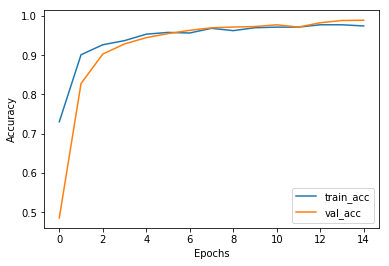

In [72]:
plt.plot(val_acc_values)
plt.plot(train_acc_values)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train_acc', 'val_acc'])
plt.show()

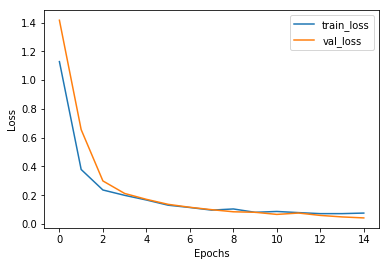

In [73]:
plt.plot(val_loss_values)
plt.plot(train_loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train_loss', 'val_loss'])
plt.show()